**Student Name:** Ayanda Sibusiso Dlamini

**Student ID :** 411221337

**Department :** CSIE

**Grade:** Juniour

# **ASSIGNMENT 1**

CNN model using the PyTorch framework with the Cat and Dog


*The process of building a Convolutional Neural Network always involves four major steps.*

**Step - 1 : Convolution**

**Step - 2 : Pooling**

**Step - 3 : Flattening**

**Step - 4 : Full connection**


In [1]:
# Check PyTorch & GPU
import torch, torchvision
print("torch:", torch.__version__, "cuda:", torch.cuda.is_available())
!nvidia-smi -L || true   # shows GPU if available (safe if not)


torch: 2.8.0+cu126 cuda: True
GPU 0: Tesla T4 (UUID: GPU-a72f4c6b-3879-bc1e-00e7-7162fd4d7a33)


🧩 Step 1: Mount Google Drive in Colab



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Locating My Dataset

In [3]:
!ls /content/drive/MyDrive/GenAI/cats_dogs


test_set.zip


Unzip the Dataset

In [4]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/GenAI/cats_dogs/test_set.zip'
extract_path = '/content/dataset'

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files to:", extract_path)


Extracted files to: /content/dataset


In [5]:
!ls /content/dataset


test_set


Split test_set into train and val

In [6]:
import os
import glob
import shutil
import random

random.seed(42)

src_dir = '/content/dataset/test_set'
output_root = '/content/dataset'
val_split = 0.2  # 20% for validation

for cls in ['cats', 'dogs']:
    imgs = glob.glob(os.path.join(src_dir, cls, '*.*'))
    random.shuffle(imgs)
    split_idx = int(len(imgs) * (1 - val_split))

    # train folder
    train_folder = os.path.join(output_root, 'train', cls)
    os.makedirs(train_folder, exist_ok=True)
    for img_path in imgs[:split_idx]:
        shutil.copy(img_path, train_folder)

    # val folder
    val_folder = os.path.join(output_root, 'val', cls)
    os.makedirs(val_folder, exist_ok=True)
    for img_path in imgs[split_idx:]:
        shutil.copy(img_path, val_folder)

print("Dataset split complete!")
print("Train folder:", os.listdir(os.path.join(output_root, 'train')))
print("Val folder:", os.listdir(os.path.join(output_root, 'val')))


Dataset split complete!
Train folder: ['cats', 'dogs']
Val folder: ['cats', 'dogs']


Load the datasets with DataLoaders

In [7]:
# Import datasets and transforms from torchvision for handling image data and augmentations
from torchvision import datasets, transforms
# Import DataLoader to efficiently load batches of data during training
from torch.utils.data import DataLoader

# Define the target size for images (width and height)
img_size = 128
# Define the batch size for training and validation
batch_size = 32

# Define transformations for training data
train_tfms = transforms.Compose([
    # Resize all images to img_size x img_size
    transforms.Resize((img_size,img_size)),
    # Apply random horizontal flip for data augmentation
    transforms.RandomHorizontalFlip(),
    # Convert images to PyTorch tensors
    transforms.ToTensor()
])

# Define transformations for validation data
val_tfms = transforms.Compose([
    # Resize images to img_size x img_size
    transforms.Resize((img_size,img_size)),
    # Convert images to PyTorch tensors
    transforms.ToTensor()
])

# Load training dataset from folder and apply training transformations
train_dataset = datasets.ImageFolder('/content/dataset/train', transform=train_tfms)
# Load validation dataset from folder and apply validation transformations
val_dataset = datasets.ImageFolder('/content/dataset/val', transform=val_tfms)

# Create DataLoader for training dataset with batch processing and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create DataLoader for validation dataset with batch processing, no shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print the class labels detected in the dataset
print("Classes:", train_dataset.classes)
# Print the total number of training samples
print("Number of training samples:", len(train_dataset))
# Print the total number of validation samples
print("Number of validation samples:", len(val_dataset))


Classes: ['cats', 'dogs']
Number of training samples: 1617
Number of validation samples: 406


Definition the CNN model and training

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check if GPU is available and use it, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple Convolutional Neural Network for binary classification (cats vs dogs)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels, kernel size 3
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # Max pooling layer with 2x2 window
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer: 32 input channels, 64 output channels, kernel size 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Fully connected layer: 64*32*32 input features, 128 output features
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        # Output layer: 128 input features, 2 output classes (cats and dogs)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # Apply first conv layer, ReLU activation, then max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second conv layer, ReLU activation, then max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps into a vector for the fully connected layers
        x = x.view(-1, 64 * 32 * 32)
        # Apply first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply output layer (no activation here because CrossEntropyLoss includes softmax)
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the device (GPU or CPU)
model = SimpleCNN().to(device)

# Define the loss function for classification
criterion = nn.CrossEntropyLoss()
# Define the optimizer (Adam) with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs for training
epochs = 5

from tqdm import tqdm  # import tqdm for progress bar

# Training loop with progress bar
for epoch in range(epochs):
    running_loss = 0.0
    # Wrap train_loader with tqdm to show progress
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # Move data to device (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, labels)
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print average loss at the end of the epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save the trained model to a file
torch.save(model.state_dict(), '/content/cats_dogs_cnn.pth')
print("Model saved successfully!")


Epoch 1/5: 100%|██████████| 51/51 [00:06<00:00,  8.20it/s]


Epoch [1/5], Loss: 0.8407


Epoch 2/5: 100%|██████████| 51/51 [00:05<00:00,  9.53it/s]


Epoch [2/5], Loss: 0.6863


Epoch 3/5: 100%|██████████| 51/51 [00:04<00:00, 10.62it/s]


Epoch [3/5], Loss: 0.6792


Epoch 4/5: 100%|██████████| 51/51 [00:05<00:00,  8.95it/s]


Epoch [4/5], Loss: 0.6734


Epoch 5/5: 100%|██████████| 51/51 [00:04<00:00, 10.67it/s]

Epoch [5/5], Loss: 0.6466
Model saved successfully!


Set up a validation loop and also plot graphs for training and validation performance (loss and accuracy).

Epoch 1/30: 100%|██████████| 51/51 [00:04<00:00, 10.47it/s]


Epoch [1/30] -> Train Loss: 0.7352, Train Acc: 53.06%, Val Loss: 0.6770, Val Acc: 59.61%


Epoch 2/30: 100%|██████████| 51/51 [00:06<00:00,  7.93it/s]


Epoch [2/30] -> Train Loss: 0.6815, Train Acc: 56.83%, Val Loss: 0.6761, Val Acc: 56.65%


Epoch 3/30: 100%|██████████| 51/51 [00:04<00:00, 10.72it/s]


Epoch [3/30] -> Train Loss: 0.6784, Train Acc: 56.22%, Val Loss: 0.6752, Val Acc: 56.65%


Epoch 4/30: 100%|██████████| 51/51 [00:05<00:00,  9.05it/s]


Epoch [4/30] -> Train Loss: 0.6670, Train Acc: 59.18%, Val Loss: 0.6786, Val Acc: 57.88%


Epoch 5/30: 100%|██████████| 51/51 [00:04<00:00, 10.65it/s]


Epoch [5/30] -> Train Loss: 0.6552, Train Acc: 60.67%, Val Loss: 0.6822, Val Acc: 57.39%


Epoch 6/30: 100%|██████████| 51/51 [00:05<00:00,  8.92it/s]


Epoch [6/30] -> Train Loss: 0.6371, Train Acc: 62.77%, Val Loss: 0.6756, Val Acc: 60.10%


Epoch 7/30: 100%|██████████| 51/51 [00:04<00:00, 10.70it/s]


Epoch [7/30] -> Train Loss: 0.5847, Train Acc: 69.08%, Val Loss: 0.7221, Val Acc: 59.61%


Epoch 8/30: 100%|██████████| 51/51 [00:05<00:00,  8.88it/s]


Epoch [8/30] -> Train Loss: 0.5495, Train Acc: 72.05%, Val Loss: 0.6816, Val Acc: 63.79%


Epoch 9/30: 100%|██████████| 51/51 [00:04<00:00, 10.55it/s]


Epoch [9/30] -> Train Loss: 0.4904, Train Acc: 75.02%, Val Loss: 0.7259, Val Acc: 59.11%


Epoch 10/30: 100%|██████████| 51/51 [00:05<00:00,  8.96it/s]


Epoch [10/30] -> Train Loss: 0.4205, Train Acc: 81.14%, Val Loss: 0.8452, Val Acc: 59.61%


Epoch 11/30: 100%|██████████| 51/51 [00:05<00:00,  9.56it/s]


Epoch [11/30] -> Train Loss: 0.3922, Train Acc: 82.00%, Val Loss: 1.0214, Val Acc: 60.59%


Epoch 12/30: 100%|██████████| 51/51 [00:05<00:00,  8.94it/s]


Epoch [12/30] -> Train Loss: 0.3296, Train Acc: 85.96%, Val Loss: 0.8964, Val Acc: 60.84%


Epoch 13/30: 100%|██████████| 51/51 [00:04<00:00, 10.50it/s]


Epoch [13/30] -> Train Loss: 0.2622, Train Acc: 89.12%, Val Loss: 0.8990, Val Acc: 62.32%


Epoch 14/30: 100%|██████████| 51/51 [00:05<00:00,  8.99it/s]


Epoch [14/30] -> Train Loss: 0.2178, Train Acc: 91.59%, Val Loss: 1.0466, Val Acc: 60.84%


Epoch 15/30: 100%|██████████| 51/51 [00:04<00:00, 10.66it/s]


Epoch [15/30] -> Train Loss: 0.1616, Train Acc: 94.12%, Val Loss: 1.1497, Val Acc: 64.04%


Epoch 16/30: 100%|██████████| 51/51 [00:05<00:00,  9.51it/s]


Epoch [16/30] -> Train Loss: 0.1311, Train Acc: 95.30%, Val Loss: 1.2585, Val Acc: 64.29%


Epoch 17/30: 100%|██████████| 51/51 [00:04<00:00, 10.63it/s]


Epoch [17/30] -> Train Loss: 0.1020, Train Acc: 96.72%, Val Loss: 1.3409, Val Acc: 62.07%


Epoch 18/30: 100%|██████████| 51/51 [00:05<00:00,  9.89it/s]


Epoch [18/30] -> Train Loss: 0.0655, Train Acc: 97.96%, Val Loss: 1.4513, Val Acc: 61.82%


Epoch 19/30: 100%|██████████| 51/51 [00:04<00:00, 10.42it/s]


Epoch [19/30] -> Train Loss: 0.0463, Train Acc: 98.64%, Val Loss: 1.5751, Val Acc: 61.08%


Epoch 20/30: 100%|██████████| 51/51 [00:04<00:00, 10.56it/s]


Epoch [20/30] -> Train Loss: 0.0406, Train Acc: 99.20%, Val Loss: 1.7830, Val Acc: 61.82%


Epoch 21/30: 100%|██████████| 51/51 [00:05<00:00,  9.81it/s]


Epoch [21/30] -> Train Loss: 0.0272, Train Acc: 99.63%, Val Loss: 1.8976, Val Acc: 61.08%


Epoch 22/30: 100%|██████████| 51/51 [00:04<00:00, 10.59it/s]


Epoch [22/30] -> Train Loss: 0.0455, Train Acc: 98.58%, Val Loss: 1.7853, Val Acc: 61.33%


Epoch 23/30: 100%|██████████| 51/51 [00:05<00:00,  9.28it/s]


Epoch [23/30] -> Train Loss: 0.0246, Train Acc: 99.32%, Val Loss: 1.8831, Val Acc: 62.07%


Epoch 24/30: 100%|██████████| 51/51 [00:04<00:00, 10.72it/s]


Epoch [24/30] -> Train Loss: 0.0215, Train Acc: 99.51%, Val Loss: 2.2195, Val Acc: 63.55%


Epoch 25/30: 100%|██████████| 51/51 [00:05<00:00,  8.89it/s]


Epoch [25/30] -> Train Loss: 0.0100, Train Acc: 99.69%, Val Loss: 2.1897, Val Acc: 63.55%


Epoch 26/30: 100%|██████████| 51/51 [00:04<00:00, 10.74it/s]


Epoch [26/30] -> Train Loss: 0.0069, Train Acc: 99.88%, Val Loss: 2.3159, Val Acc: 62.56%


Epoch 27/30: 100%|██████████| 51/51 [00:05<00:00,  8.92it/s]


Epoch [27/30] -> Train Loss: 0.0119, Train Acc: 99.63%, Val Loss: 2.6623, Val Acc: 62.56%


Epoch 28/30: 100%|██████████| 51/51 [00:04<00:00, 10.68it/s]


Epoch [28/30] -> Train Loss: 0.0715, Train Acc: 98.14%, Val Loss: 2.0369, Val Acc: 63.30%


Epoch 29/30: 100%|██████████| 51/51 [00:05<00:00,  8.93it/s]


Epoch [29/30] -> Train Loss: 0.0734, Train Acc: 97.90%, Val Loss: 1.9579, Val Acc: 62.56%


Epoch 30/30: 100%|██████████| 51/51 [00:04<00:00, 10.72it/s]


Epoch [30/30] -> Train Loss: 0.0126, Train Acc: 99.75%, Val Loss: 2.0655, Val Acc: 65.02%
Model saved successfully!


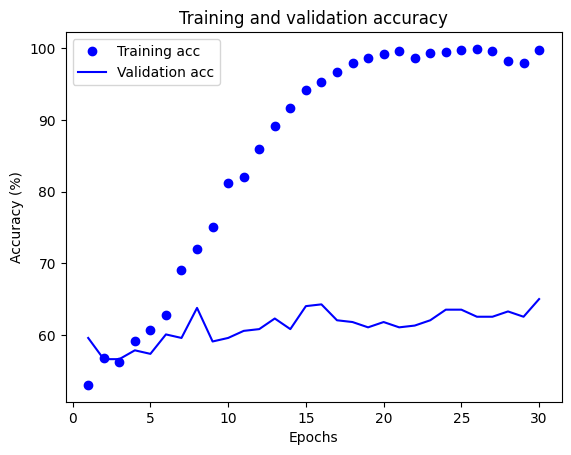

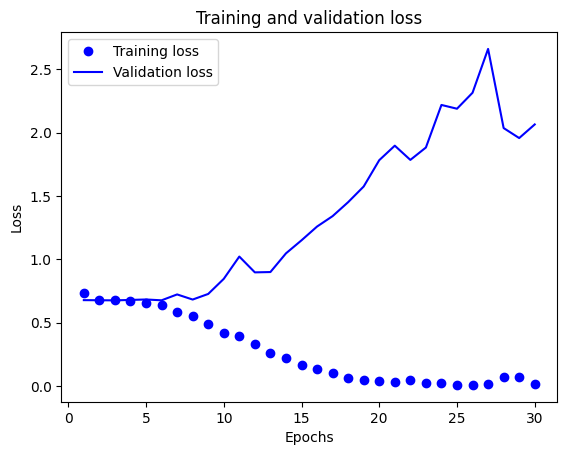

In [9]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check if GPU is available and use it, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple Convolutional Neural Network for binary classification (cats vs dogs)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: 3 input channels (RGB), 32 output channels, kernel size 3
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # Max pooling layer with 2x2 window
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer: 32 input channels, 64 output channels, kernel size 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Fully connected layer: 64*32*32 input features, 128 output features
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        # Output layer: 128 input features, 2 output classes (cats and dogs)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # Apply first conv layer, ReLU activation, then max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second conv layer, ReLU activation, then max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the feature maps into a vector for the fully connected layers
        x = x.view(-1, 64 * 32 * 32)
        # Apply first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply output layer (no activation here because CrossEntropyLoss includes softmax)
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the device (GPU or CPU)
model = SimpleCNN().to(device)

# Define the loss function for classification
criterion = nn.CrossEntropyLoss()
# Define the optimizer (Adam) with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs to match the original notebook for better accuracy
epochs = 30

# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Validation function
def validate(model, val_loader, criterion):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # no gradients needed
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Training loop with validation at each epoch
from tqdm import tqdm  # import tqdm for progress bar

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for training
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Run validation
    val_loss, val_accuracy = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] -> "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), 'cats_and_dogs_small_1.pth')
print("Model saved successfully!")

# ------------------------------
# Keras-style plotting
# ------------------------------
epochs_range = range(1, epochs+1)

# Accuracy graph
plt.plot(epochs_range, train_accuracies, 'bo', label='Training acc')  # blue dots
plt.plot(epochs_range, val_accuracies, 'b', label='Validation acc')  # blue line
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.figure()

# Loss graph
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')  # blue dots
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')  # blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now i need to improve the accuracy by incorporating Batch Normalization and Dropout.

Using device: cuda
Epoch [1/30] | Train Loss: 1.3361 | Val Loss: 1.0182 | Train Acc: 52.06% | Val Acc: 63.66%
Epoch [2/30] | Train Loss: 1.0393 | Val Loss: 0.8645 | Train Acc: 63.04% | Val Acc: 69.70%
Epoch [3/30] | Train Loss: 0.9110 | Val Loss: 0.7984 | Train Acc: 67.76% | Val Acc: 72.00%
Epoch [4/30] | Train Loss: 0.8171 | Val Loss: 0.7302 | Train Acc: 71.24% | Val Acc: 74.91%
Epoch [5/30] | Train Loss: 0.7422 | Val Loss: 0.7178 | Train Acc: 73.89% | Val Acc: 75.22%
Epoch [6/30] | Train Loss: 0.6835 | Val Loss: 0.6627 | Train Acc: 75.97% | Val Acc: 77.26%
Epoch [7/30] | Train Loss: 0.6230 | Val Loss: 0.6731 | Train Acc: 77.76% | Val Acc: 76.78%
Epoch [8/30] | Train Loss: 0.5782 | Val Loss: 0.6697 | Train Acc: 79.62% | Val Acc: 77.07%
Epoch [9/30] | Train Loss: 0.5349 | Val Loss: 0.6518 | Train Acc: 81.04% | Val Acc: 77.80%
Epoch [10/30] | Train Loss: 0.4894 | Val Loss: 0.6415 | Train Acc: 82.64% | Val Acc: 78.62%
Epoch [11/30] | Train Loss: 0.4595 | Val Loss: 0.6414 | Train Acc: 83.

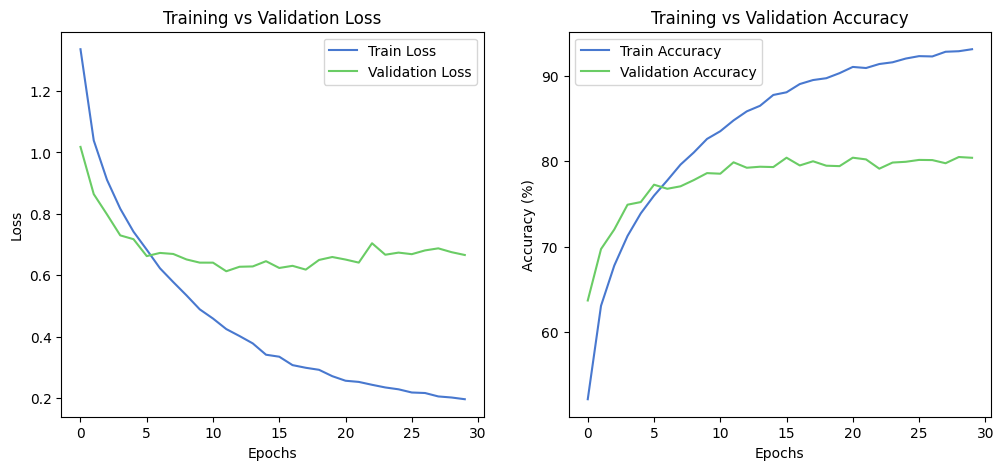

In [16]:
# ===================== Improved CNN with BatchNorm + Dropout (30 epochs + Plot) =====================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os

# ===================== Device Setup =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===================== Data Transform =====================
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ===================== Dataset and Split =====================
train_dataset_full = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split training dataset into train and validation sets (80/20)
train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ===================== Define CNN =====================
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # Automatically compute flatten size
        self.flatten_dim = self._get_flatten_dim()
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _get_flatten_dim(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 64, 64)
            x = self.conv_layers(x)
            return x.numel()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# ===================== Initialize Model =====================
model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# ===================== Training + Validation =====================
for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# ===================== Test Accuracy =====================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f"\n✅ Test Accuracy: {test_accuracy:.2f}%")

# ===================== Save Model =====================
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), "saved_models/improved_bn_dropout_30epochs.pth")
print("💾 Model saved as: saved_models/improved_bn_dropout_30epochs.pth")

# ===================== Plot =====================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
# ===================== Improved CNN with BatchNorm + Dropout + Augmentation + Scheduler (30 epochs + Plot) =====================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os

# ===================== Device Setup =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===================== Data Transform + Augmentation =====================
img_size = 128
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_val = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ===================== Dataset and Split =====================
train_dataset_full = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_val, download=True)

train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ===================== Define CNN =====================
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.flatten_dim = self._get_flatten_dim()
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def _get_flatten_dim(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, img_size, img_size)
            x = self.conv_layers(x)
            return x.numel()

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# ===================== Initialize Model =====================
model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# ===================== Training + Validation =====================
for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# ===================== Test Accuracy =====================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f"\n✅ Test Accuracy: {test_accuracy:.2f}%")

# ===================== Save Model =====================
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), "saved_models/improved_bn_dropout_aug_30epochs.pth")
print("💾 Model saved as: saved_models/improved_bn_dropout_aug_30epochs.pth")

# ===================== Plot =====================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()


Using device: cuda
Epoch [1/30] | Train Loss: 1.6039 | Val Loss: 1.2934 | Train Acc: 42.06% | Val Acc: 54.33%
Epoch [2/30] | Train Loss: 1.2814 | Val Loss: 1.1033 | Train Acc: 54.31% | Val Acc: 61.90%
Epoch [3/30] | Train Loss: 1.1521 | Val Loss: 1.0095 | Train Acc: 59.17% | Val Acc: 64.10%
Epoch [4/30] | Train Loss: 1.0725 | Val Loss: 0.9222 | Train Acc: 62.28% | Val Acc: 67.43%
Epoch [5/30] | Train Loss: 1.0194 | Val Loss: 0.9111 | Train Acc: 63.92% | Val Acc: 67.79%
Epoch [6/30] | Train Loss: 0.9685 | Val Loss: 0.8467 | Train Acc: 65.91% | Val Acc: 70.23%
Epoch [7/30] | Train Loss: 0.9342 | Val Loss: 0.8287 | Train Acc: 67.02% | Val Acc: 71.58%
Epoch [8/30] | Train Loss: 0.9043 | Val Loss: 0.8197 | Train Acc: 68.17% | Val Acc: 71.96%
Epoch [9/30] | Train Loss: 0.8733 | Val Loss: 0.8126 | Train Acc: 69.53% | Val Acc: 71.71%
Epoch [10/30] | Train Loss: 0.8554 | Val Loss: 0.7776 | Train Acc: 69.99% | Val Acc: 73.03%
Epoch [11/30] | Train Loss: 0.8375 | Val Loss: 0.7859 | Train Acc: 70.